In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

from grid_and_bathy import build_grid, get_grid_angle

In [2]:
grid_resolution_ini=50
nx_ini=1344; ny_ini=528  #Ny initially set to 120

# point of origin in swiss grid 
x0_sg = 500000
y0_sg = 116500

# second point for tilted grid
x1_sg = 563000
y1_sg = 138700

In [3]:
xy_land = np.loadtxt(r"C:\Users\leroquan\Documents\Data\mitgcm_grids\Geneva\shoreline.txt")
output_folder = r'C:\Users\leroquan\Documents\00-Work_space\06-mit_gcm_geneva\data\grid\dummy'

In [54]:
def plot_grid(x_arr: np.array, y_arr: np.array):
    for i_row in range(x_arr.shape[0]):
        for i_column in range(x_arr.shape[1]):
            x_col = [x_arr[i_row, i_column], x_arr[i_row-1, i_column]]
            y_col = [y_arr[i_row, i_column], y_arr[i_row-1, i_column]]
            plt.plot(x_col, y_col, 'k-', lw=1, color='darkred')  # Draw columns
            
            x_line = [x_arr[i_row, i_column], x_arr[i_row, i_column-1]]
            y_line = [y_arr[i_row, i_column], y_arr[i_row, i_column-1]]
            plt.plot(x_line, y_line, lw=1, color='darkred')  # Draw columns

# Creating grid

In [57]:
factor = 4
grid_resolution = grid_resolution_ini * factor
nx = nx_ini / factor
ny = ny_ini / factor

x, y, x_rotated, y_rotated, lat_grid, lon_grid = build_grid(nx, ny, grid_resolution, grid_resolution, x0_sg, y0_sg, x1_sg, y1_sg)

# Simple plot

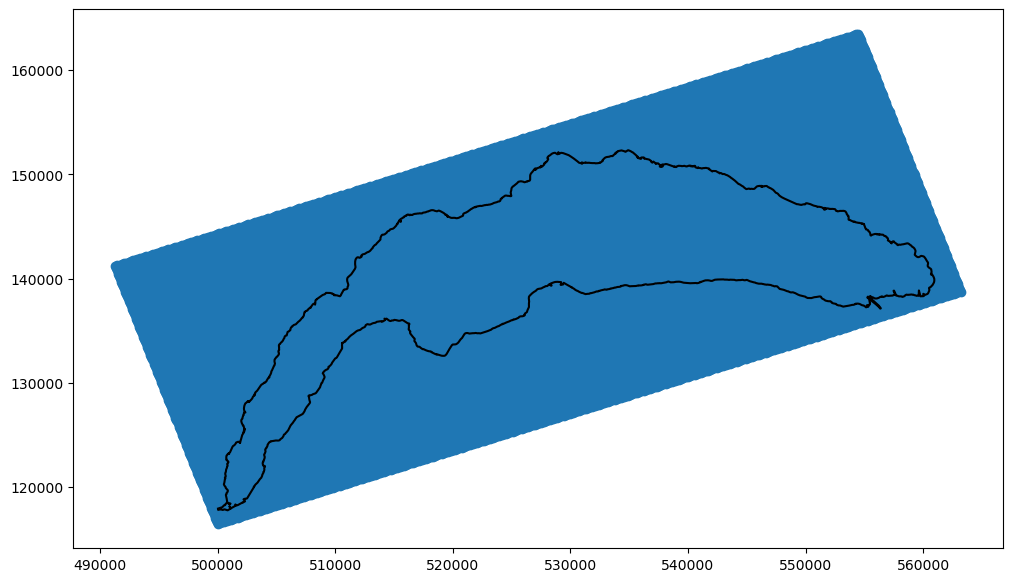

In [58]:
plt.close('all')
plt.figure(figsize=(12,7))
plt.scatter(x_rotated.flatten(), y_rotated.flatten())
plt.plot(xy_land[:,0], xy_land[:,1], color='black', zorder=2)
plt.show()

# Display core allocation

In [78]:
Px = 12 #48
Py = 3 #12

x_res_cores = nx * grid_resolution / Px
y_res_cores = ny * grid_resolution / Py

print(f'x_res_cores: {x_res_cores}, y_res_cores: {y_res_cores}')

x_cores, y_cores, x_rotated_cores, y_rotated_cores, lat_grid_cores, lon_grid_cores = build_grid(Px+1, Py+1, x_res_cores, y_res_cores, x0_sg, y0_sg, x1_sg, y1_sg)

C:\Users\leroquan\AppData\Local\Temp\ipykernel_23520\2844172201.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_col, y_col, 'k-', lw=1, color='darkred')  # Draw columns


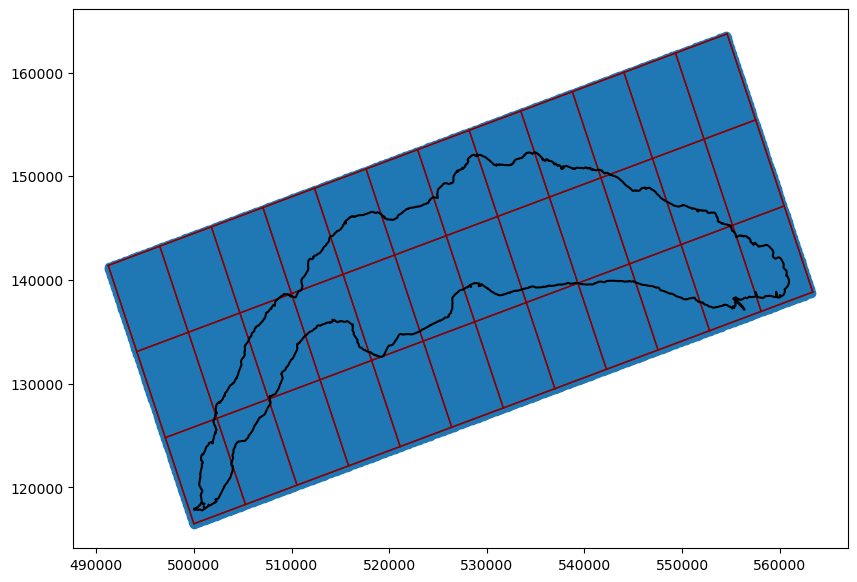

In [79]:
plt.close('all')
plt.figure(figsize=(10,7))
plt.scatter(x_rotated.flatten(), y_rotated.flatten())
plot_grid(x_rotated_cores, y_rotated_cores)
plt.plot(xy_land[:,0], xy_land[:,1], color='black', zorder=2)
plt.show()


# Save grid

In [ ]:
with open(os.path.join(output_folder, 'x.npy'), 'wb') as f:
    np.save(f, x)

with open(os.path.join(output_folder, 'y.npy'), 'wb') as f:
    np.save(f, y)

with open(os.path.join(output_folder, 'x_sg_grid.npy'), 'wb') as f:
    np.save(f, x_rotated)

with open(os.path.join(output_folder, 'y_sg_grid.npy'), 'wb') as f:
    np.save(f, y_rotated)

with open(os.path.join(output_folder, 'lat_grid.npy'), 'wb') as f:
    np.save(f, lat_grid)

with open(os.path.join(output_folder, 'lon_grid.npy'), 'wb') as f:
    np.save(f, lon_grid)